In [1]:
using Revise

In [2]:
using BeamPropagation, Distributions, PhysicalConstants.CODATA2018, StatsBase, StaticArrays, Plots, BenchmarkTools, DelimitedFiles, StructArrays, Interpolations

In [3]:
# Define molecule parameters
const λ = @with_unit 626 "nm"
const m = @with_unit 57 "u"
const Γ = 1/(25e-9)
;

In [4]:
# Define molecular beam characteristics
vz_μ = @with_unit 125 "m/s"
vz_σ = @with_unit 25 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 25 "m/s" #approximately 4 K
exit_radius = @with_unit 4 "mm"
;

In [5]:
# Define physical constants
const h = PlanckConstant.val
const ħ = h / 2π
const k = 2π / λ
const Δv = ħ * k / m

0.011182985018419364

In [6]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [7]:
@inline function random_unit3Dvector()
    θ = rand(Uniform(0, 2π))
    z = rand(Uniform(-1, 1))
    return @SVector [sqrt(1-z^2)*cos(θ), sqrt(1-z^2)*sin(θ), z]
end
;

In [8]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 81  "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 2.0 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [9]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

# @inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len) #|| (r[3] < -0.05)
@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len) || (v[3] < -30) #|| (r[3] < -0.05)

@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
#     for i in 1:size(particles, 1)
#         idx = particles.idx[i]
#         v = particles.v[i]
#         s.vzs[idx] = v[3]
#     end
    return nothing
end
;

In [10]:
@inline function transverse_on(z)
    if 0.175 < z < 0.20     # 1st transverse region 17.5 - 20 cm after cell
        return true
    elseif 0.45 < z < 0.50  # 2nd transverse region 45 - 50 cm after cell
        return true
    elseif 0.56 < z < 0.61  # 2nd transverse region 56 - 61 cm after cell
        return true
    else
        return false
    end
end
;

In [11]:
# updated VBRs 9/28/21
VBRs = Weights([
    0.946961,     # to 000
    0.046456,     # 100
    2.585e-3,     # 0200
    1.708e-3,     # 200
    6.38e-4,     # 0220
    8.16e-4,     # 0110
    3.58e-4,     # 0110, N=2
    1.95e-4,     # 1200
    6.5e-5,     # 300
    4.9e-5,     # 1220
    6.0e-5,     # 110 N=1
    2.4e-5,     # 110, N=2
    2.8e-5,     # 030 N=1
    5.7e-5      # other statess
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    true,   # 1220
    false,   # 110
    false,  # 110, N=2
    false,  # 030 N=1
    false   # other states
]

transverse = [
    false,  # to 000
    false,   # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 0110, N=2
    false,  # 1200
    false,   # 300
    false,   # 1220
    false,   # 110
    false,   # 110, N=2
    false,  # 030 N=1
    false   # other states
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    566,
    623,
    651,
    595,
    646,
    566,
    648,
    600,
    600
]

;

In [12]:
io = open("Rsc270MHzReal.txt","r")
Rsc300 = readdlm(io,Float64)
close(io)

In [13]:
Iaxis = Rsc300[1:501,2];
vaxis = Rsc300[1:501:end,1];
Rscarray = zeros(length(vaxis),length(Iaxis))
for i in 1:length(vaxis)
    Rscarray[i,:] = Rsc300[501*(i-1).+(1:501),3] 
end
Rsc_interp = LinearInterpolation((vaxis, Iaxis), Rscarray)
;

In [14]:
@inline function beamwaist(z, p)
    
    waist = (z*(p.ddet-p.dcell)/(detect_zloc)+p.dcell)/2
    if waist > 0
        return waist
    else
        return p.dcell
    end
    #guards against possibility of getting 0 waist (and hence a NaN in the intensity) when at very negative z positions
    
end
;

In [15]:
@inline function velocity_vector(r, v, Δvphot, p)
    
    focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
    z = r[3] + focus_offset
    
    length = sqrt(r[1]^2 + r[2]^2 + z^2)
    
    x_comp = r[1] / length
    y_comp = r[2] / length
    z_comp = z / length
    
    return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
end

;

In [16]:
# the interesting physics (scattering rate vs. position, velocity etc.) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
    vmin = -100.
    vmax = 250.
    if vmin < v[3]-p.voff < vmax
        waist = beamwaist(r[3],p)
        I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
        Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
        if isnan(Ir)
            Ir = 0
        end
        Rsc = p.ζ*p.Rsc_interp(v[3]-p.voff,Ir)
    else
        Rsc = 0.
    end
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [17]:
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200. #mW
ζ = 0.15
voff = 0. #offset of bottom edge of sidebands from zero
p = @params (ddet, dcell, power, ζ, voff, Rsc_interp)
rs = 0:0.01:0.81
Rscatts0 = zeros(size(rs,1))
Rscatts1 = zeros(size(rs,1))
Rscatts2 = zeros(size(rs,1))
Rscatts3 = zeros(size(rs,1))
Rscatts4 = zeros(size(rs,1))
Rscatts5 = zeros(size(rs,1))
for i in 1:length(rs)
    Rscatts0[i] = Rscatt(SVector(0.,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts1[i] = Rscatt(SVector(1e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts2[i] = Rscatt(SVector(2e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts3[i] = Rscatt(SVector(3e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts4[i] = Rscatt(SVector(4e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts5[i] = Rscatt(SVector(5e-3,0.,rs[i]),SVector(0.,0.,100.),p)
end

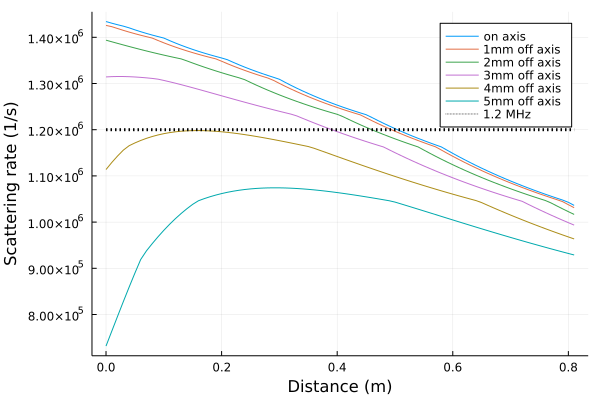

In [18]:
plot(rs,Rscatts0, label = "on axis")
plot!(rs,Rscatts1, label = "1mm off axis")
plot!(rs,Rscatts2, label = "2mm off axis")
plot!(rs,Rscatts3, label = "3mm off axis")
plot!(rs,Rscatts4, label = "4mm off axis")
plot!(rs,Rscatts5, label = "5mm off axis")
plot!([0.,0.81],[1.2e6,1.2e6],lw = 3, linestyle = :dot, color = "black", label = "1.2 MHz")
xlabel!("Distance (m)")
ylabel!("Scattering rate (1/s)")

In [19]:
vs = -40:1:200
Rscatts = zeros(size(vs,1))
for i in 1:length(vs)
    Rscatts[i] = Rscatt(SVector(0.,0.,0.5),SVector(0.,0.,vs[i]),p)
end

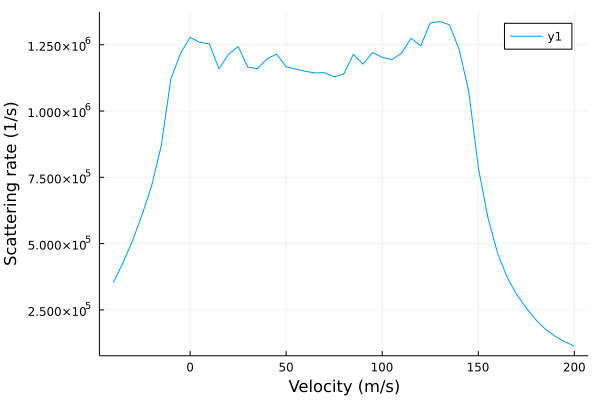

In [20]:
plot(vs,Rscatts)
xlabel!("Velocity (m/s)")
ylabel!("Scattering rate (1/s)")

In [21]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
        p.total_time[idx] += particles.dt[i]
        
        if ~p.noslow && p.addressed[state] #&& (p.turn_on < p.total_time[idx] < p.turn_off) # (v[3] > p.ult_cutoff) #&& (~p.transverse[state] || transverse_on(r[3]))
            dt′ = update_Rsc(r,v,p)
            state′ = sample(1:14, p.VBRs)
            particles.dt[i] = dt′
            particles.use_adaptive[i] = false
            v′ = velocity_vector(r, v, Δv, p)
            v′ += Δv * random_unit3Dvector()
            s.photons[idx] += 1
        else
            state′ = state
            v′ = v
            particles.use_adaptive[i] = false
        end
        
        s.states[idx] = state′
        s.vzs[idx] = v′[3]
        particles.v[i] = v′
        
        s.detectable[idx] |= (is_detectable(r) && p.addressed[state′])
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end

;

In [22]:
n = Int64(1e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(3e5)
alg = "rkf12"
use_adaptive = false
dt0 = 1e-5
;

In [23]:
ddet = 0.02 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 400 #mW
ζ = 0.15
voff = 60. #offset of bottom edge of sidebands from zero
ult_cutoff = -50.
turn_on = 0e-3
turn_off = 50e-3
;

In [24]:
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
noslow = false
total_time = zeros(Float64, n)

exit_time = Beta(2, 5)
total_time .+= rand(exit_time, n) * 1e-3

p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp, ult_cutoff, total_time, turn_off, turn_on)
s = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true)

  4.234507 seconds (3.02 M allocations: 344.246 MiB, 3.15% gc time, 23.45% compilation time)


In [28]:
# Slowing lasers turned off
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
total_time = zeros(Float64, n)
noslow = true
total_time = zeros(Float64, n)

exit_time = Beta(2, 5)
total_time .+= rand(exit_time, n) * 1e-3

p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp, ult_cutoff, total_time, turn_off, turn_on)
s0 = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, 
    dt_min, dt_max, abstol, true)

 10.921572 seconds (36 allocations: 185.015 MiB, 0.08% gc time)


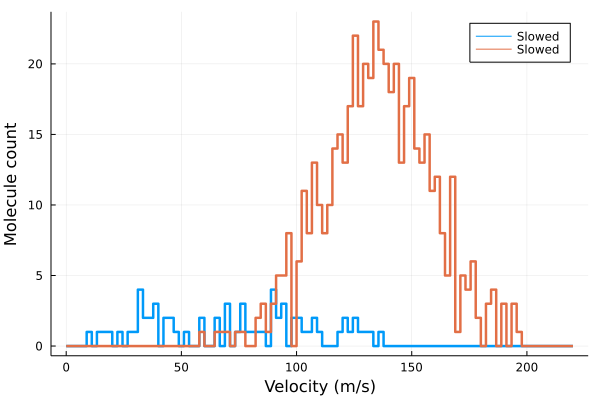

In [29]:
pbins = range(0, stop=220, length=100)
plot(s.vzs[s.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="Slowed")
plot!(s0.vzs[s0.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="Slowed")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [30]:
success_ = sum(s.vzs[s.detectable] .< 10) / sum(s0.detectable)

0.0

In [31]:
success_ * 2e7

0.0

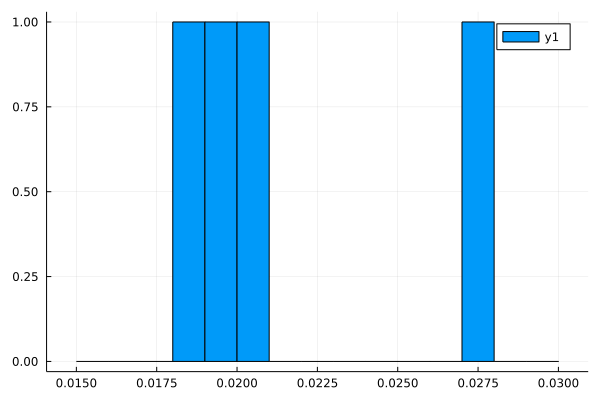

In [32]:
histogram(p.total_time[(s.vzs .< 20) .&& s.detectable], bins=0.015:0.001:0.030)

### Scan power and detuning, i.e., lower velocity cutoff of white-light broadened sidebands

In [186]:
powers = [200, 400, 600, 800, 1000, 1200]
ddets = [0.01, 0.02, 0.03]
results = []

for ddet in ddets
    for power in powers
        photons = zeros(Int64, n)
        detectable = zeros(Bool, n)
        states = ones(Int64, n)
        vzs = zeros(Float64, n)
        noslow = false
        total_time = zeros(Float64, n)

        exit_time = Beta(2, 5)
        total_time .+= rand(exit_time, n) * 1e-3

        p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp, ult_cutoff, total_time, turn_off, turn_on)
        s = @params (vzs, photons, detectable, states)
        particles = StructArray{Particle}(undef, n)

        @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true)
        
        success_ = sum(s.vzs[s.detectable] .< 15) / sum(s0.detectable)
        
        println(ddet)
        println(power)
        println(success_ * 2e7)
        println()
        
        push!(results, success_ * 2e7)
    end
end

 46.174844 seconds (424 allocations: 7.227 GiB, 4.58% gc time)
0.01
200
132132.13213213213

 69.348816 seconds (424 allocations: 7.227 GiB, 2.96% gc time)
0.01
400
144144.14414414414

 76.452325 seconds (423 allocations: 7.227 GiB, 2.46% gc time)
0.01
600
108108.10810810812

 79.994485 seconds (423 allocations: 7.227 GiB, 2.55% gc time)
0.01
800
140140.14014014014

 83.691263 seconds (424 allocations: 7.227 GiB, 2.48% gc time)
0.01
1000
88088.0880880881

 68.386781 seconds (423 allocations: 7.227 GiB, 3.32% gc time)
0.01
1200
124124.12412412412

 46.905454 seconds (424 allocations: 7.227 GiB, 4.31% gc time)
0.02
200
24024.024024024024

 85.733383 seconds (431 allocations: 7.227 GiB, 2.59% gc time)
0.02
400
212212.2122122122

 80.738607 seconds (425 allocations: 7.227 GiB, 2.66% gc time)
0.02
600
264264.26426426426

 86.364705 seconds (424 allocations: 7.227 GiB, 2.27% gc time)
0.02
800
292292.2922922923

 90.213112 seconds (425 allocations: 7.227 GiB, 2.17% gc time)
0.02
1000
256256.25